In [ ]:
!pip install -qy pandas numpy seaborn matplotlib torch
!pip install pmdarima -U
!pip install --upgrade pmdarima==2.0.2



Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -y
  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)
  Attempting uninstall: pmdarima
    Found existing installation: pmdarima 2.0.2
    Uninstalling pmdarima-2.0.2:
      Successfully uninstalled pmdarima-2.0.2
  Using cached pmdarima-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (1.9 MB)
  Attem

In [ ]:
!pip install torchtext
!pip install portalocker
!pip install torchdata
!pip install --user transformers
!pip install --user datasets
!pip install --user torchmetrics==1.4.0.post0
!pip install --user accelerate
!pip install --user torchvision
!pip install --user trl
!pip install --user protobuf


In [ ]:
import torch
from torchmetrics import Accuracy
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import pipeline, AutoModelForSequenceClassification, AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM

from tqdm.auto import tqdm
import math
import time
import matplotlib.pyplot as plt

def warn(*args, **kwargs):
  pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# Supervised Fine-tuning with PyTorch

# Supervised Fine-tuning with Pytorch

Fine-tuning Transformers, specifically BERT (Bidirectional Encoder Representations from Transformers), refers to the process of training a pretrained BERT model on a specific downstream task. BERT is an encoder-only language model that has been pretrained on a large corpus of text to learn contextual representations of words.

Fine-tuning BERT involves taking the pretrained model and further training it on a task-specific dataset, such as sentiment analysis or question answering. During fine-tuning, the parameters of the pretrained BERT model are updated and adapted to the specifics of the target task.

This process is important because it allows you to leverage the knowledge and language understanding captured by BERT and apply it to different tasks. By fine-tuning BERT, you can benefit from its contextual understanding of language and transfer that knowledge to specific domain-specific or task-specific problems. Fine-tuning enables BERT to learn from a smaller labeled dataset and generalize well to unseen examples, making it a powerful tool for various natural language processing tasks. It helps to bridge the gap between pretraining on a large corpus and the specific requirements of downstream applications, ultimately improving the performance and effectiveness of models in various real-world scenarios.

## Dataset preparations

The Yelp review dataset is a widely used dataset in natural language processing (NLP) and sentiment analysis research. It consists of user reviews and accompanying metadata from the Yelp platform, which is a popular online platform for reviewing and rating local businesses such as restaurants, hotels, and shops.

The dataset includes 6,990,280 reviews written by Yelp users, covering a wide range of businesses and locations. Each review typically contains the text of the review itself alongwith the star rating given by the user (ranging from 1 to 5).

Our aim in this lab, is to fine-tune a pretrained BERT model to predict the ratings from reviews.

In [ ]:
dataset = load_dataset("yelp_review_full")

dataset

README.md:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [ ]:
dataset["train"][100]

{'label': 0,
 'text': 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. 

In [ ]:
dataset["train"][100]["label"]

0

In [ ]:
dataset["train"][100]['text']

'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. I\'ve worked at more t

In [ ]:
dataset["train"] = dataset["train"].select([i for i in range(1000)])
dataset["test"] = dataset["test"].select([i for i in range(200)])

## Tokenizing data

In [ ]:
print(type(dataset))

<class 'datasets.dataset_dict.DatasetDict'>


In [ ]:
# Instantiate a tokenizer using the BERT base cased model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Define a function to tokenizer examples
def tokenize_function(examples):
  # Tokenize the text using the tokenizer
  # Apply padding to ensure all sequences have the same length
  # Apply truncation to limit maximum sequence length
  return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply the tokenize function to the dataset in batches
tokenized_datasets = dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets['train'][0].keys()

dict_keys(['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'])

To apply the preprocessing function over the entire dataset, let's use the map method. You can speed up the map function by setting batched=True to process multiple elements of the dataset at once:

Since the model is built on the PyTorch framework, it is crucial to prepare the dataset in a format that PyTorch can readily process. Follow these steps to ensure compatibility:

In [ ]:
# Remove the text column because the model does not accept raw text as an input
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

# Rename the label column to labels because the model expects the argument to be named labels
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Set the format of the dataset to return PyTorch tensors instead of lists
tokenized_datasets.set_format("torch")

the result is a set of tensors with the keys as:  'labels', 'input_ids', 'token_type_ids', 'attention_mask'

In [ ]:
tokenized_datasets['train'][0].keys()

dict_keys(['labels', 'input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
print(type(tokenized_datasets))

<class 'datasets.dataset_dict.DatasetDict'>


# DataLoader

Next, create a DataLoader for trainand test datasets so you can iterate over batches of data:

In [ ]:
# Create a training data loader
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=2)

# CReate an evaluation data loader
eval_dataloader = DataLoader(tokenized_datasets["test"], batch_size=2)

## Train the model

You’re ready to start training your model, now!
In this section, you will learn to create the training loop from scratch without the help of the Hugging Face trainer class.
In the MLM task, you utilized the Hugging Face trainer module. Now, you will develop the trainer yourself.

## Load a pretrained model

Here, you'll load a pretrined classification model with 5 classes:

In [ ]:
# Instantiate a sequence classification model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Optimizer and learning rate schedule

Let's create an optimizer and lerning rate scheduler tomfine-tune the model.  Youcan use the AdamW optimizer from PyTorch:

In [ ]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-4)

# Set the number of epochs
num_epochs = 10

# Calcuate the total number of training steps
num_training_steps = num_epochs * len(train_dataloader)

# Define the learning rate scheduoer
lr_scheduler = LambdaLR(optimizer, lr_lambda=lambda current_step: (1 - current_step / num_training_steps))


In [ ]:
import torch
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move the model to the appropriate device
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Training loop

You are ready to fine-tune the model. To keep track of training progress, let's use the "tqdm" library to add a progress bar over the number of training steps.
The train_model function trains a model using a set of training data provided through a dataloader. It begins by setting up a progress bar to help monitor the training progress visually. The model is switched to training mode, which is necessary for certain model behaviors like dropout to work correctly during training. The function processes the data in batches for each epoch, which involves several steps for each batch: transferring the data to the correct device (like a GPU), running the data through the model to get outputs and calculate loss, updating the model's parameters using the calculated gradients, adjusting the learning rate, and clearing the old gradients. These steps are repeated for each batch of data, and the progress bar is updated accordingly to reflect the progress. Once all epochs are completed, the trained model is saved to be used later.

In [ ]:
def train_model(model, tr_dataloader):

  # Create a progress bar to track the training progress
  progress_bar = tqdm(range(num_training_steps))


  # Set the model in training mode
  model.train()
  tr_losses =[]
  #Training loop
  for epoch in range(num_epochs):
    total_loss = 0
    # Iterate over the training data batches
    for batch in tr_dataloader:
      # move the batach to the appropriate device
      batch = {k: v.to(device) for k, v in batch.items()}
      # Forward pass through the model
      outputs = model(**batch)
      # Compute the loss
      loss = outputs.loss
      # Backware pass (compute gradients)
      loss.backward()

      total_loss += loss.item()
      # Update the model parameters
      optimizer.step()
      # Update the learning rate scheduler
      lr_scheduler.step()
      # Clera the gradients
      optimizer.zero_grad()
      # Update the progress bar
      progress_bar.update(1)
    tr_losses.append(total_loss/len(tr_dataloader))

  # Plot loss
  plt.plot(tr_losses)
  plt.title("Training loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()




## Evaluate

The evaluate_model function works similarly to the train_model function but is used for evaluating the model's performance instead of training it. It uses a dataloader to process data in batches, setting the model to evaluation mode to ensure accuracy in measurements and disabling gradient calculations since it's not training. The function calculates predictions for each batch, updates an accuracy metric, and finally, prints the overall accuracy after processing all batches.

In [ ]:
def evaluate_model(model, evl_dataloader):

  # Create an instance of the Accurac metric for multiclass classification with 5 classes
  metric = Accuracy (task = "multiclass", num_classes = 5).to(device)

  # Set the model in evaluation mode
  model.eval()

  # Disable gradient calculation during evaluation
  with torch.no_grad():
    # Iterate over the evaluation data batches
    for batch in eval_dataloader:
      # Move the batch to the appropriate device
      batch = {k: v.to(device) for k, v in batch.items()}

      # Forward pass through the model
      outputs = model(**batch)

      # Get the predicted class labels
      logits = outputs.logits
      predictions = torch.argmax(logits, dim=-1)

      # Accumulate the predictions and labels for the metric
      metric(predictions, batch["labels"])

  # Compute the accuracy
  accuracy = metric.compute()

  # Print the accuracy
  print("Accuracy", accuracy.item())

You can now train the model. This process will take a long time, and it is highly recommended that you do this only if you have the required resources. Please uncomment the following code to train the model.

  0%|          | 0/5000 [00:00<?, ?it/s]

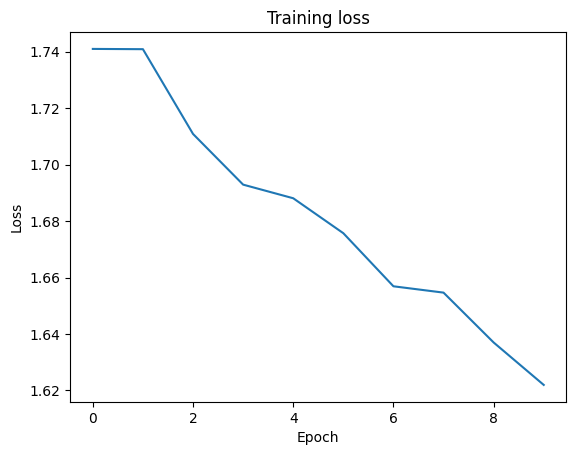

In [ ]:
train_model(model=model, tr_dataloader=train_dataloader)

torch.save(model, 'my_model.pt')


# Loading the saved model

In [ ]:
!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/wFhKpkBMSgjmZKRSyayvsQ/bert-classification-model.pt'
model.load_state_dict(torch.load('bert-classification-model.pt',map_location=torch.device('cpu')))

--2025-06-03 07:00:56--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/wFhKpkBMSgjmZKRSyayvsQ/bert-classification-model.pt
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 433341834 (413M) [binary/octet-stream]
Saving to: ‘bert-classification-model.pt’

bert-classification 100%[===================>] 413.27M  41.2MB/s    in 11s     

2025-06-03 07:01:07 (38.8 MB/s) - ‘bert-classification-model.pt’ saved [433341834/433341834]



<All keys matched successfully>

In [ ]:
evaluate_model(model, eval_dataloader)

Accuracy 0.26499998569488525


Training a conversational model using SFTTrainer

The SFTTrainer from the trl (Transformers Reinforcement Learning) library is a tool used for supervised fine-tuning of language models. It helps refine pre-trained models using specific datasets to enhance their performance on targeted tasks.

## Objective

Explore how fine-tuning a decoder transformer using a specific dataset affects the quality of the generated responses in a question-answering task.

Step 1 - Load the train split of "timdettmers/openassistnt-guanaco" dataset from HIgging Face:

In [ ]:
dataset = load_dataset("timdettmers/openassistant-guanaco", split="train")
dataset[0]


README.md:   0%|          | 0.00/395 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


openassistant_best_replies_train.jsonl:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

openassistant_best_replies_eval.jsonl:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9846 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/518 [00:00<?, ? examples/s]

{'text': '### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining po

Step 2 - Load the pretrained causal model "facebook/opt-350m" along with its tokenizer from Hugging Face:

In [ ]:
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m")
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/662M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Step 3 - Create instruction and response templates based on the train dataset format:

In [ ]:
instruction_template = "### Human:"
response_template = "### Assistant:"

Step 4 - Create a collator to curate data in the appropriate shape for training using "DataCollatorForCompletionOnly LM":

In [ ]:
collator = DataCollatorForCompletionOnlyLM(instruction_template=instruction_template, response_template=response_template, tokenizer=tokenizer, mlm=False)

Step 5 - Create an SFTTrainer object and pass the m ode as well as the dataset and collator:

In [ ]:
training_args = SFTConfig(
    output_dir="/tmp",
    num_train_epochs=10,
    #learning_rate=2e-5,
    save_strategy="epoch",
    fp16=True,
    per_device_train_batch_size=2,  # Reduce batch size
    per_device_eval_batch_size=2,  # Reduce batch size
    #gradient_accumulation_steps=4,  # Accumulate gradients
    max_seq_length=1024,
    do_eval=True,
    dataset_text_field="text"
)

trainer = SFTTrainer(
    model,
    args=training_args,
    train_dataset=dataset,
    data_collator=collator,
)

Converting train dataset to ChatML:   0%|          | 0/9846 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/9846 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/9846 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/9846 [00:00<?, ? examples/s]

Step 6 - Prompt the pretrained model with a specific question:

In [ ]:
pipe = pipeline("text-generation", model=model,tokenizer=tokenizer,max_new_tokens=70)
print(pipe('''Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.''')[0]["generated_text"])

Device set to use cuda:0
Both `max_new_tokens` (=70) and `max_length`(=21) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research. in the of the other of the in the " to the need of the the cost of the to the to the the of the of the out of the the of the of the of the of, of the the of the of the of the of the of the of the the of the of to the of of the of the of of of the


Step 6A - TRained the model:

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: petkao (petkao-peter-kao-associates) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,3.881200
1000,3.112800
1500,2.902000
2000,2.689100
2500,2.586400
3000,2.572400
3500,2.468100
4000,2.437800
4500,2.406500
5000,2.328600


TrainOutput(global_step=49230, training_loss=1.5255736120682337, metrics={'train_runtime': 17833.0019, 'train_samples_per_second': 5.521, 'train_steps_per_second': 2.761, 'total_flos': 1.1468194496171213e+17, 'train_loss': 1.5255736120682337})